# Find Lanes


In [1]:
import os
import sys
from pathlib import Path
import polars as pl
import pandas as pd
import plotly.graph_objects as go
import utm
import h3

repo_root = Path(os.getcwd()).parent

while not (repo_root / ".git").exists():
    repo_root = repo_root.parent

sys.path.append(str(repo_root))

# set the pandas plotting backend to plotly
pd.options.plotting.backend = "plotly"


## Load Radar Data


In [43]:
## Read in the Data
from src.filtering import Filtering


df = pl.scan_parquet(
    "/Users/max/Library/CloudStorage/Box-Box/Radar-Data/new_format/167865*.parquet"
).collect()


# create the file paths
network_outline_file = repo_root / "geo_data" / "network_outline.geojson"
radar_locations_file = repo_root / "geo_data" / "radar_origins.json"

f = Filtering(
    radar_location_path=radar_locations_file,
    network_boundary_path=network_outline_file,
)

df = (
    df.pipe(f.create_object_id).pipe(f.crop_radius, radius=250)
    # resample to 10 Hz
    .pipe(f.resample, 100)
    # remove objects that travel for very little time
    .pipe(f.filter_short_trajectories, minimum_distance_m=100, minimum_duration_s=5)
    # clip trajectories to not include the constant speed at the end
    .pipe(
        f.clip_trajectory_end,
    )
    # rotate the heading measurements to world coordinates
    .pipe(f.rotate_heading)
    # update the centroid coordinates to the actual center of the object
    .pipe(
        f.correct_center,
        x_col="utm_x",
        y_col="utm_y",
    )
    # convert the h3 integer to a string
    .pipe(f.int_h3_2_str)
    # filter out objects that are not in the network
    .pipe(f.filter_network_boundaries)
)


function: crop_radius took: 0.3989102840423584 seconds
function: resample took: 0.9799060821533203 seconds
function: filter_short_trajectories took: 0.23811793327331543 seconds
function: clip_trajectory_end took: 0.5581598281860352 seconds
function: direction_to_degrees took: 0.0045928955078125 seconds
function: rotate_heading took: 3.5292208194732666 seconds
function: correct_center took: 0.025743722915649414 seconds
function: int_h3_2_str took: 0.5690581798553467 seconds
function: filter_network_boundaries took: 0.12212705612182617 seconds


### Just Look at One TL


In [44]:
# interest_df = df.filter(pl.col("ip") == "10.160.7.142")


In [45]:
f.h3_resolution = 15
df = df.pipe(f.radar_to_h3)
df = df.pipe(f.radar_to_h3, resolution=13, col_name="h3_13")
df = df.pipe(f.radar_to_h3, resolution=14, col_name="h3_14")


function: radar_to_h3 took: 3.9634439945220947 seconds
function: radar_to_h3 took: 3.6033966541290283 seconds
function: radar_to_h3 took: 3.7362420558929443 seconds


### Create a DataFrame of Neighbors


In [46]:
h3_df = df.groupby("h3").agg(
    pl.col("h3").count().alias("count"),
    pl.col("h3_13").first().alias("h3_13"),
)

kring_df = (
    h3_df.select(["h3", "count"])
    .with_columns(
        [
            pl.col("h3").apply(lambda x: list(h3.k_ring(x, 1))).alias("kring"),
        ]
    )
    .explode("kring")
)


In [47]:
keep_h3 = (
    kring_df.join(
        h3_df.select(["h3", "count", "h3_13"]),
        left_on="kring",
        right_on="h3",
    )
    .groupby("h3")
    .agg(
        pl.col("count_right").sum().alias("neighbor_count"),
        (pl.col("count_right") > 0).sum().alias("neighbor_count_nonzero"),
        pl.col("count").first().alias("count"),
    )
    .with_columns(
        [
            (pl.col("count") / pl.col("neighbor_count")).alias("density"),
        ]
    )
    .filter((pl.col("density") > 0.15) & (pl.col("neighbor_count_nonzero") > 3))["h3"]
    .to_list()
)


In [48]:
df.filter(pl.col("h3").is_in(keep_h3)).select([
    'lat', 'lon'
]).write_csv(repo_root / "data" / "lane-finder.csv")

#### Plot the x/y data in a scatter plot


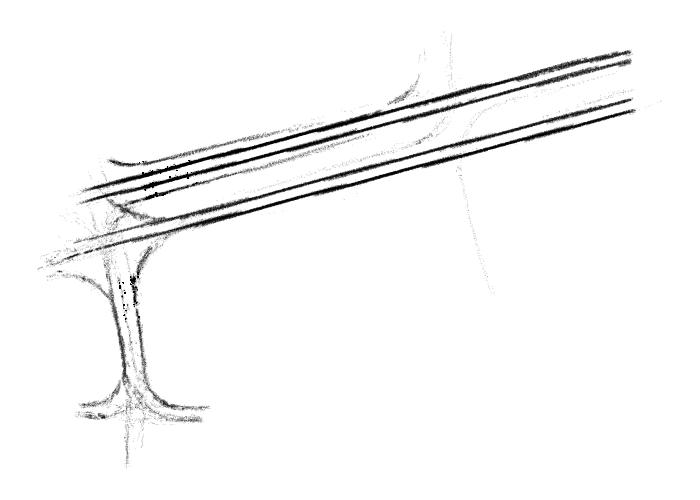

In [41]:
fig = go.Figure()

_df = df.filter(pl.col("h3").is_in(keep_h3))

_df = _df.filter(
    pl.col("ip").str.contains('142')
)

fig.add_trace(
    go.Scatter(
        x=_df["utm_x"],
        y=_df["utm_y"],
        mode="markers",
        marker=dict(
            size=1,
            # color=_df["f32_velocityInDir_mps"],
            color="black",
            # set the alpha to 0.5
            opacity=0.2,
        ),
    )
)

# make the image square
fig.update_layout(
    autosize=False,
    # width=800,
    # height=800,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
    ),
)
# plot with a white background and no x and y axis
fig.update_layout(
    plot_bgcolor="white",
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    xaxis_visible=False,
    yaxis_visible=False,
)

# make figure span the whole figure
fig.update_layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0,
    )
)

# write to a huge figure
fig.write_image(
    repo_root / "lane-finder.png",
    width=2400,
    height=2400,
)
# SHOW AS image
fig.show(renderer="png")

In [31]:
def recursive_to_utm(l: list) -> list:
    if isinstance(l[0], (list, tuple)):
        return [recursive_to_utm(x) for x in l]
    else:
        return utm.from_latlon(l[1], l[0])[:2]

In [33]:
utmer = recursive_to_utm(h3_utm)

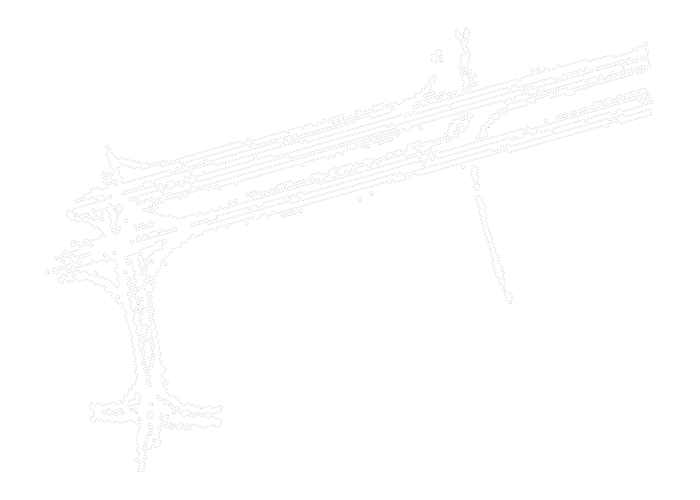

In [39]:
fig = go.Figure()

_df = df.filter(pl.col("h3").is_in(keep_h3))

_df = _df.filter(
    pl.col("ip").str.contains('142')
)

# get the h3s
h3s = _df['h3'].unique().to_list()

# get the h3s in utm coordinates
h3_utm = h3.h3_set_to_multi_polygon(h3s, geo_json=True)


l = recursive_to_utm(h3_utm)
l = recursive_to_utm(h3_utm)

for _l in l:
    for __l in _l:
        fig.add_trace(
            go.Scatter(
                x=[x[0] for x in __l],
                y=[x[1] for x in __l],
                mode="markers",
                marker=dict(
                    color="black",
                    # width=0,
                    opacity=0.2,
                    size=1
                ),
                # fill="toself",
                showlegend=False,
            )
        )



# fig.add_trace(
#     go.Scatter(
#         x=_df["utm_x"],
#         y=_df["utm_y"],
#         mode="markers",
#         marker=dict(
#             size=1,
#             # color=_df["f32_velocityInDir_mps"],
#             color="black",
#             # set the alpha to 0.5
#             opacity=0.2,
#         ),
#     )
# )

# make the image square
fig.update_layout(
    autosize=False,
    # width=800,
    # height=800,
    xaxis=dict(
        scaleanchor="y",
        scaleratio=1,
    ),
)
# plot with a white background and no x and y axis
fig.update_layout(
    plot_bgcolor="white",
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    xaxis_visible=False,
    yaxis_visible=False,
)

# make figure span the whole figure
fig.update_layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0,
    )
)

# write to a huge figure
fig.write_image(
    repo_root / "lane-finder.png",
    width=2400,
    height=2400,
)
# SHOW AS image
fig.show(renderer="png")